In [1]:
import sam
sam

/home/felix/Desktop/sam


<module 'sam' from '/home/felix/Desktop/sam/src/sam/__init__.py'>

In [2]:
import glob
from sam.stress_addition_model import (
    sam_prediction,
    Predicted_LCs,
    get_sam_lcs,
    SAM_Setting,
    StandardSettings,
    OLD_STANDARD,
    NEW_STANDARD,
)
from sam.helpers import compute_lc, find_lc_99_max, compute_lc_from_curve
from sam.plotting import plot_sam_prediction
from sam.data_formats import ExperimentData, read_data
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm
import numpy as np
from scipy.optimize import brentq
from scipy.stats import beta


def surv_to_stress_new(x0):
    x0 = np.clip(x0, 0,1-1e-7)   
    x0 = 1-x0
    pred = 0.000995 + np.log(0.907 * x0) / (x0 - (1.09 / x0))
    
    return np.clip(pred, 0, 1)
    

MIN_VAL = surv_to_stress_new(1 - 1e-9)

@np.vectorize
def stress_to_surv_new(y):
    
    y = np.clip(y, MIN_VAL, 1)


    def equation(x0):
        return surv_to_stress_new(x0) - y

    # Use brentq to find the root of the equation in the interval [0, 1]
    try:
        x0_inverse = brentq(
            equation, 0, 1 - 1e-9
        )  # Start from a small positive value to avoid division by zero
        return x0_inverse
    except ValueError as e:
        raise ValueError(
            f"Cannot find a root in the interval [0, 1] for y = {y}. Error: {e}"
        )

In [3]:
stress_to_surv_new(1.1)

array(0.)

In [4]:
surv_to_stress_new(1)

0.0009964876796763134

In [5]:
surv_to_stress_new(0.1)

0.6534093216869428

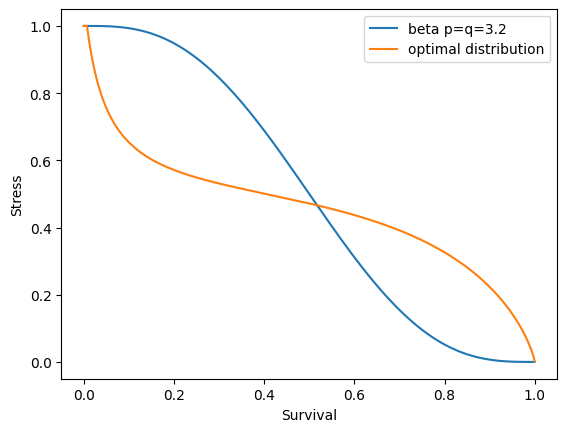

In [6]:
x = np.linspace(0,1,1000)
plt.plot(x, beta.cdf(1 - x,3.2,3.2), label = "beta p=q=3.2")
plt.plot(x, surv_to_stress_new(x), label = "optimal distribution")
plt.xlabel("Survival")
plt.ylabel("Stress")
plt.legend()
plt.show()

In [26]:
MIN_VAL = surv_to_stress_new(1 - 1e-9)

@np.vectorize
def stress_to_surv_new(y):
    y = np.maximum(y, MIN_VAL)


    def equation(x0):
        return surv_to_stress_new(x0) - y

    # Use brentq to find the root of the equation in the interval [0, 1]
    try:
        x0_inverse = brentq(
            equation, 0, 1 - 1e-9
        )  # Start from a small positive value to avoid division by zero
        return x0_inverse
    except ValueError as e:
        raise ValueError(
            f"Cannot find a root in the interval [0, 1] for y = {y}. Error: {e}"
        )

In [30]:
stress_to_surv_new(0.99)

array(0.00802679)

In [4]:
df = pd.read_csv("sam_predictions.csv", index_col=0)

for col in ["stress_lc10","stress_lc50","sam_lc10","sam_lc50"]:
    df[col] /= df.survival_max

In [8]:
r2_score(df.stress_lc10, df.sam_lc10)

-0.13685788487634487

In [9]:
r2_score(df.stress_lc50, df.sam_lc50)

0.1490235813442191